# Coursework 1  - Exercise 3

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

You should initially explore the hyperparameters involved in this algorithm. You should then carry out experiments
to compare the following (all using Adam):
- L2 regularization vs. weight decay
- constant learning rate vs. cosine annealing schedule
- no restarts in the scheduler vs. use of a warm restart

Game plan:
1. explore random L2 regularization factors
2. explore random weight decay factors
3. Assume they are decoupled and compare both
4. Explore const alpha vs. cosine annealing with adam+weight_decay
5. Explore no restarts vs warm restarts with adam+weight_decay


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, scheduler, valid_data, data_monitors, notebook=notebook)
    
    # Check if we don't have any residuals
    stat = optimiser.eval_monitors(valid_data, "valid")
    print("Starting accuracy is", stat)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    stat_test = optimiser.eval_monitors(test_data, "test")
    
    return stats, stat_test, keys, run_time, fig_1, ax_1, fig_2, ax_2, learning_rule.learning_rate

In [2]:
def plot_stats(stat, title=None, save=False, filename=None):
    stats, keys, run_time, _, _, _, _, _ = stat
    fig, axs = plt.subplots(2,1, figsize=(6,8))
    
    if title is not None:
#         learn_rate = title.split(",")[0]
        plt.suptitle(title)

    for k in ['error(train)', 'error(valid)']:
        axs[0].plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    axs[0].legend(loc=0)
    axs[0].set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    for k in ['acc(train)', 'acc(valid)']:
        axs[1].plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    axs[1].legend(loc=0)
    axs[1].set_xlabel('Epoch number')
    
    if(save):
        plt.savefig(filename + ".pdf")

In [3]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider
from mlp.schedulers import ConstantLearningRateScheduler, CosineAnnealingWithWarmRestarts
from mlp.initialisers import ConstantInit, GlorotUniformInit

# Seed a random number generator
seed = 11102018 
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# define possilb schedulers
# schedulers_sgd = [ConstantLearningRateScheduler(0.005),
#               CosineAnnealingWithWarmRestarts(min_learning_rate=0.0005, max_learning_rate=0.005,
#                                                        total_iters_per_period=10e+30,
#                                                        max_learning_rate_discount_factor=0.9,
#                                                        period_iteration_expansion_factor=1.0),
#               CosineAnnealingWithWarmRestarts(min_learning_rate=0.0005, max_learning_rate=0.005,
#                                                        total_iters_per_period=25,
#                                                        max_learning_rate_discount_factor=0.9,
#                                                        period_iteration_expansion_factor=3.0)
#              ]

# schedulers_adam = [ConstantLearningRateScheduler(0.0001),
#               CosineAnnealingWithWarmRestarts(min_learning_rate=0.00001, max_learning_rate=0.0001,
#                                                        total_iters_per_period=10e+30,
#                                                        max_learning_rate_discount_factor=0.9,
#                                                        period_iteration_expansion_factor=1.0),
#               CosineAnnealingWithWarmRestarts(min_learning_rate=0.00001, max_learning_rate=0.0001,
#                                                        total_iters_per_period=25,
#                                                        max_learning_rate_discount_factor=0.9,
#                                                        period_iteration_expansion_factor=3.0)
#              ]

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f3dd8e7ed68>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f3dd8e74240>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f3dd8e7ed68>)


Starting accuracy is OrderedDict([('errorvalid', 3.8706851787401413), ('accvalid', 0.02588607594936706)])


Epoch 10: 4.1s to complete
    error(train)=5.28e-01, acc(train)=8.22e-01, error(valid)=6.64e-01, acc(valid)=7.98e-01


Epoch 20: 4.2s to complete
    error(train)=4.94e-01, acc(train)=8.41e-01, error(valid)=6.81e-01, acc(valid)=8.13e-01


Epoch 30: 4.3s to complete
    error(train)=4.57e-01, acc(train)=8.52e-01, error(valid)=6.69e-01, acc(valid)=8.18e-01


Epoch 40: 4.4s to complete
    error(train)=4.40e-01, acc(train)=8.51e-01, error(valid)=7.03e-01, acc(valid)=8.12e-01


Epoch 50: 4.4s to complete
    error(train)=4.47e-01, acc(train)=8.55e-01, error(valid)=7.19e-01, acc(valid)=8.15e-01


Epoch 60: 4.5s to complete
    error(train)=4.30e-01, acc(train)=8.59e-01, error(valid)=7.13e-01, acc(valid)=8.20e-01


Epoch 70: 4.5s to complete
    error(train)=4.62e-01, acc(train)=8.57e-01, error(valid)=7.87e-01, acc(valid)=8.17e-01


Epoch 80: 4.5s to complete
    error(train)=5.25e-01, acc(train)=8.57e-01, error(valid)=9.42e-01, acc(valid)=8.16e-01


Epoch 90: 4.5s to complete
    error(train)=5.12e-01, acc(train)=8.40e-01, error(valid)=8.38e-01, acc(valid)=8.04e-01


Epoch 100: 4.5s to complete
    error(train)=4.93e-01, acc(train)=8.48e-01, error(valid)=8.65e-01, acc(valid)=8.12e-01


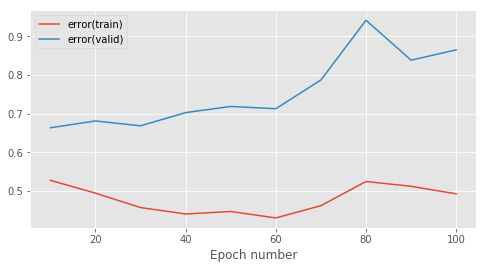

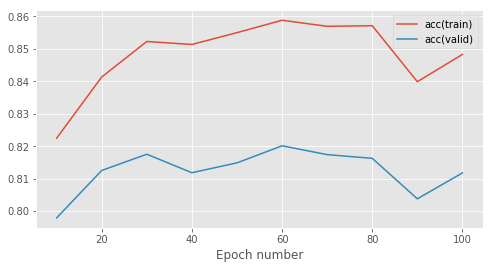

In [4]:
# Simple model with SGD and 3 hidden layers. To be used as baseline
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.learning_rules import AdamLearningRule
from mlp.schedulers import ConstantLearningRateScheduler, CosineAnnealingWithWarmRestarts
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty

#setup hyperparameters
learning_rate = 0.005
batch = 100
num_epochs = 100
stats_interval = 10
input_dim, output_dim, hidden_dim = 784, 47, 100

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

scheduler = ConstantLearningRateScheduler(learning_rate=learning_rate)

#Remember to use notebook=False when you write a script to be run in a terminal
res_sgd = train_model_and_plot_stats(
    model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True)


Starting accuracy is OrderedDict([('errorvalid', 3.858835674490415), ('accvalid', 0.020379746835443007)])


Epoch 10: 1.9s to complete
    error(train)=6.80e-01, acc(train)=7.93e-01, error(valid)=7.04e-01, acc(valid)=7.82e-01


Epoch 20: 1.9s to complete
    error(train)=5.38e-01, acc(train)=8.28e-01, error(valid)=5.89e-01, acc(valid)=8.14e-01


Epoch 30: 2.0s to complete
    error(train)=4.72e-01, acc(train)=8.46e-01, error(valid)=5.49e-01, acc(valid)=8.26e-01


Epoch 40: 2.0s to complete
    error(train)=4.16e-01, acc(train)=8.62e-01, error(valid)=5.21e-01, acc(valid)=8.32e-01


Epoch 50: 1.9s to complete
    error(train)=3.90e-01, acc(train)=8.69e-01, error(valid)=5.21e-01, acc(valid)=8.33e-01


Epoch 60: 2.0s to complete
    error(train)=3.71e-01, acc(train)=8.74e-01, error(valid)=5.28e-01, acc(valid)=8.33e-01


Epoch 70: 2.0s to complete
    error(train)=3.35e-01, acc(train)=8.86e-01, error(valid)=5.24e-01, acc(valid)=8.36e-01


Epoch 80: 2.1s to complete
    error(train)=3.21e-01, acc(train)=8.89e-01, error(valid)=5.38e-01, acc(valid)=8.35e-01


Epoch 90: 2.0s to complete
    error(train)=3.03e-01, acc(train)=8.95e-01, error(valid)=5.48e-01, acc(valid)=8.34e-01


Epoch 100: 2.0s to complete
    error(train)=2.91e-01, acc(train)=8.98e-01, error(valid)=5.54e-01, acc(valid)=8.33e-01


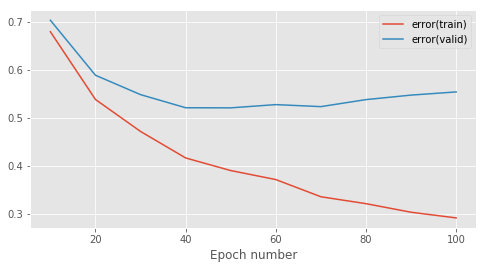

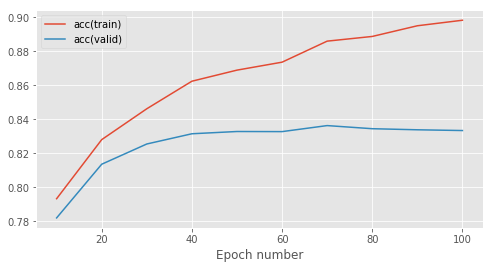

In [5]:
# Simple model with RMSProp and 3 hidden layers
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.learning_rules import RMSPropLearningRule
from mlp.schedulers import ConstantLearningRateScheduler, CosineAnnealingWithWarmRestarts
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty

#setup hyperparameters
learning_rate = 0.0001
batch = 100
num_epochs = 100
stats_interval = 10
input_dim, output_dim, hidden_dim = 784, 47, 100

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = RMSPropLearningRule(learning_rate=learning_rate)

scheduler = ConstantLearningRateScheduler(learning_rate=learning_rate)

#Remember to use notebook=False when you write a script to be run in a terminal
res_rms = train_model_and_plot_stats(
    model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True)


Starting accuracy is OrderedDict([('errorvalid', 3.8642042520142), ('accvalid', 0.013924050632911394)])


Epoch 10: 3.0s to complete
    error(train)=6.54e-01, acc(train)=7.97e-01, error(valid)=6.81e-01, acc(valid)=7.89e-01


Epoch 20: 3.1s to complete
    error(train)=5.17e-01, acc(train)=8.33e-01, error(valid)=5.71e-01, acc(valid)=8.18e-01


Epoch 30: 2.9s to complete
    error(train)=4.54e-01, acc(train)=8.50e-01, error(valid)=5.40e-01, acc(valid)=8.25e-01


Epoch 40: 2.9s to complete
    error(train)=4.07e-01, acc(train)=8.64e-01, error(valid)=5.18e-01, acc(valid)=8.34e-01


Epoch 50: 2.9s to complete
    error(train)=3.79e-01, acc(train)=8.70e-01, error(valid)=5.21e-01, acc(valid)=8.33e-01


Epoch 60: 3.0s to complete
    error(train)=3.50e-01, acc(train)=8.79e-01, error(valid)=5.15e-01, acc(valid)=8.35e-01


Epoch 70: 3.0s to complete
    error(train)=3.23e-01, acc(train)=8.88e-01, error(valid)=5.14e-01, acc(valid)=8.38e-01


Epoch 80: 3.0s to complete
    error(train)=3.03e-01, acc(train)=8.95e-01, error(valid)=5.21e-01, acc(valid)=8.39e-01


Epoch 90: 3.0s to complete
    error(train)=2.91e-01, acc(train)=8.96e-01, error(valid)=5.36e-01, acc(valid)=8.33e-01


Epoch 100: 2.9s to complete
    error(train)=2.76e-01, acc(train)=9.03e-01, error(valid)=5.44e-01, acc(valid)=8.37e-01


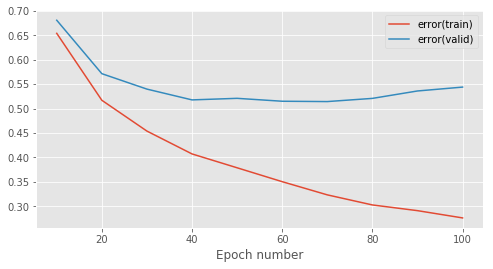

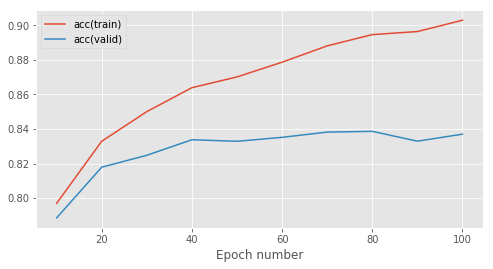

In [6]:
# Simple model with Adam and 3 hidden layers
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.learning_rules import AdamLearningRule
from mlp.schedulers import ConstantLearningRateScheduler, CosineAnnealingWithWarmRestarts
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty

#setup hyperparameters
learning_rate = 0.0001
batch = 100
num_epochs = 100
stats_interval = 10
input_dim, output_dim, hidden_dim = 784, 47, 100

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

scheduler = ConstantLearningRateScheduler(learning_rate=learning_rate)

#Remember to use notebook=False when you write a script to be run in a terminal
res_adam = train_model_and_plot_stats(
    model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True)


Starting accuracy is OrderedDict([('errorvalid', 3.8638366544222387), ('accvalid', 0.02227848101265819)])


Epoch 10: 4.1s to complete
    error(train)=4.46e-01, acc(train)=8.41e-01, error(valid)=5.81e-01, acc(valid)=8.13e-01


Epoch 20: 4.2s to complete
    error(train)=2.55e-01, acc(train)=9.00e-01, error(valid)=5.58e-01, acc(valid)=8.41e-01


Epoch 30: 4.6s to complete
    error(train)=3.39e-01, acc(train)=8.72e-01, error(valid)=6.37e-01, acc(valid)=8.18e-01


Epoch 40: 4.2s to complete
    error(train)=2.99e-01, acc(train)=8.86e-01, error(valid)=6.55e-01, acc(valid)=8.25e-01


Epoch 50: 4.2s to complete
    error(train)=2.45e-01, acc(train)=9.04e-01, error(valid)=7.22e-01, acc(valid)=8.31e-01


Epoch 60: 4.1s to complete
    error(train)=1.82e-01, acc(train)=9.25e-01, error(valid)=8.87e-01, acc(valid)=8.28e-01


Epoch 70: 4.5s to complete
    error(train)=1.27e-01, acc(train)=9.46e-01, error(valid)=1.14e+00, acc(valid)=8.27e-01


Epoch 80: 4.3s to complete
    error(train)=9.84e-02, acc(train)=9.58e-01, error(valid)=1.42e+00, acc(valid)=8.26e-01


Epoch 90: 4.2s to complete
    error(train)=2.69e-01, acc(train)=8.98e-01, error(valid)=8.96e-01, acc(valid)=8.15e-01


Epoch 100: 4.3s to complete
    error(train)=2.64e-01, acc(train)=9.00e-01, error(valid)=9.06e-01, acc(valid)=8.18e-01


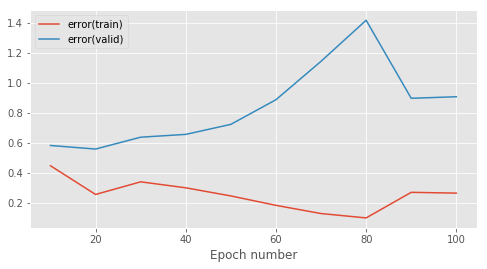

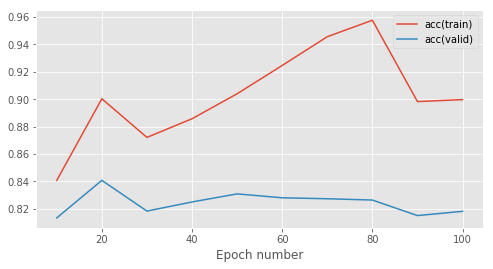

In [7]:
# Simple model with SGD and 3 hidden layers. To be used as baseline
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.learning_rules import AdamLearningRule
from mlp.schedulers import ConstantLearningRateScheduler, CosineAnnealingWithWarmRestartsPlus
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty

#setup hyperparameters
learning_rate = 0.005
batch = 100
num_epochs = 100
stats_interval = 10
input_dim, output_dim, hidden_dim = 784, 47, 100

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

scheduler = CosineAnnealingWithWarmRestarts(min_learning_rate=0.0005, max_learning_rate=0.005,
                                                       total_iters_per_period=25,
                                                       max_learning_rate_discount_factor=0.9,
                                                       period_iteration_expansion_factor=3.0)

#Remember to use notebook=False when you write a script to be run in a terminal
res_sgd_cos_plus = train_model_and_plot_stats(
    model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True)


Starting accuracy is OrderedDict([('errorvalid', 3.8648636780808943), ('accvalid', 0.014620253164556955)])


Epoch 10: 3.2s to complete
    error(train)=6.60e-01, acc(train)=7.96e-01, error(valid)=6.95e-01, acc(valid)=7.88e-01


Epoch 20: 3.2s to complete
    error(train)=5.46e-01, acc(train)=8.25e-01, error(valid)=6.01e-01, acc(valid)=8.12e-01


Epoch 30: 3.3s to complete
    error(train)=4.82e-01, acc(train)=8.41e-01, error(valid)=5.50e-01, acc(valid)=8.21e-01


Epoch 40: 3.3s to complete
    error(train)=4.45e-01, acc(train)=8.54e-01, error(valid)=5.26e-01, acc(valid)=8.31e-01


Epoch 50: 3.8s to complete
    error(train)=4.23e-01, acc(train)=8.59e-01, error(valid)=5.14e-01, acc(valid)=8.31e-01


Epoch 60: 3.3s to complete
    error(train)=4.01e-01, acc(train)=8.67e-01, error(valid)=5.00e-01, acc(valid)=8.39e-01


Epoch 70: 3.2s to complete
    error(train)=3.88e-01, acc(train)=8.68e-01, error(valid)=4.95e-01, acc(valid)=8.38e-01


Epoch 80: 3.2s to complete
    error(train)=3.69e-01, acc(train)=8.76e-01, error(valid)=4.85e-01, acc(valid)=8.41e-01


Epoch 90: 3.2s to complete
    error(train)=3.61e-01, acc(train)=8.78e-01, error(valid)=4.84e-01, acc(valid)=8.41e-01


Epoch 100: 3.2s to complete
    error(train)=3.52e-01, acc(train)=8.80e-01, error(valid)=4.83e-01, acc(valid)=8.42e-01


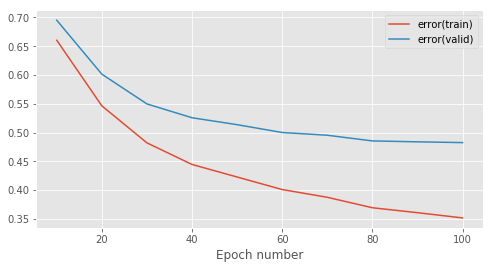

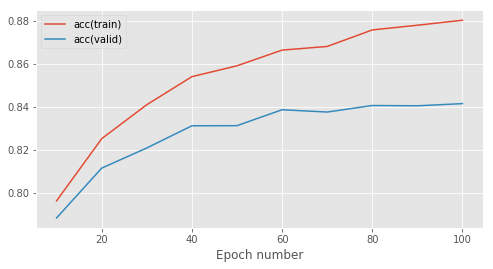

In [8]:
# Simple model with Adam and 3 hidden layers
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.learning_rules import AdamLearningRuleWithWeightDecay
from mlp.schedulers import ConstantLearningRateScheduler, CosineAnnealingWithWarmRestartsPlus
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty

#setup hyperparameters
learning_rate = 0.0001
batch = 100
num_epochs = 100
stats_interval = 10
input_dim, output_dim, hidden_dim = 784, 47, 100
wd = 1e-5

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRuleWithWeightDecay(learning_rate=learning_rate, weight_decay=wd)

scheduler = ConstantLearningRateScheduler(learning_rate=learning_rate)

#Remember to use notebook=False when you write a script to be run in a terminal
res_adam_wd = train_model_and_plot_stats(
    model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True)


Starting accuracy is OrderedDict([('errorvalid', 3.8580901285783233), ('accvalid', 0.020506329113924023)])


Epoch 10: 3.3s to complete
    error(train)=1.26e+00, acc(train)=6.50e-01, error(valid)=1.27e+00, acc(valid)=6.45e-01


Epoch 20: 3.3s to complete
    error(train)=1.05e+00, acc(train)=7.06e-01, error(valid)=1.06e+00, acc(valid)=7.02e-01


Epoch 30: 3.4s to complete
    error(train)=1.02e+00, acc(train)=7.10e-01, error(valid)=1.03e+00, acc(valid)=7.06e-01


Epoch 40: 3.4s to complete
    error(train)=8.90e-01, acc(train)=7.43e-01, error(valid)=9.03e-01, acc(valid)=7.36e-01


Epoch 50: 3.3s to complete
    error(train)=8.60e-01, acc(train)=7.53e-01, error(valid)=8.73e-01, acc(valid)=7.48e-01


Epoch 60: 3.3s to complete
    error(train)=8.93e-01, acc(train)=7.52e-01, error(valid)=9.06e-01, acc(valid)=7.49e-01


Epoch 70: 3.4s to complete
    error(train)=1.00e+00, acc(train)=7.43e-01, error(valid)=1.01e+00, acc(valid)=7.42e-01


Epoch 80: 3.3s to complete
    error(train)=1.20e+00, acc(train)=7.29e-01, error(valid)=1.22e+00, acc(valid)=7.25e-01


Epoch 90: 3.5s to complete
    error(train)=8.76e-01, acc(train)=7.46e-01, error(valid)=8.88e-01, acc(valid)=7.43e-01


Epoch 100: 3.3s to complete
    error(train)=8.17e-01, acc(train)=7.60e-01, error(valid)=8.29e-01, acc(valid)=7.56e-01


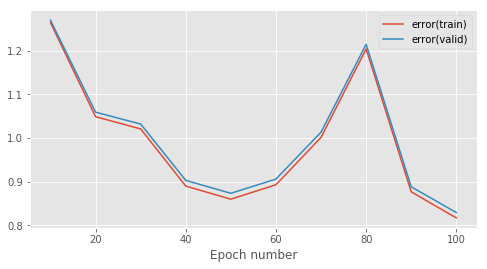

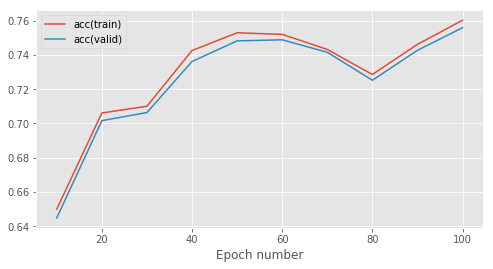

In [27]:
# Simple model with Adam and 3 hidden layers
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.learning_rules import AdamLearningRuleWithWeightDecay
from mlp.schedulers import ConstantLearningRateScheduler, CosineAnnealingWithWarmRestarts
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty

#setup hyperparameters
learning_rate = 0.0001
batch = 100
num_epochs = 100
stats_interval = 10
input_dim, output_dim, hidden_dim = 784, 47, 100
wd = 1e-5

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRuleWithWeightDecay(learning_rate=learning_rate, weight_decay=wd)

scheduler = CosineAnnealingWithWarmRestarts(min_learning_rate=0.00001, max_learning_rate=0.0001,
                                                       total_iters_per_period=25,
                                                       max_learning_rate_discount_factor=0.9,
                                                       period_iteration_expansion_factor=3.0)

#Remember to use notebook=False when you write a script to be run in a terminal
res_adam_wd_cos = train_model_and_plot_stats(
    model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True)


In [28]:
top_res = [res_sgd, res_rms, res_adam, res_sgd_cos_plus, res_adam_wd, res_adam_wd_cos]
top_res_str = ["SGD", "RMSProp", "Adam", "SGD + cos anneal", "Adam + WD", "Adam + WD + cos anneal"]

Data for SGD
Training time= 439.53785729408264
Train accuracy= 0.848280000000002
Valid accuracy= 0.811772151898734
Test accuracy= 0.7989873417721519
Data for RMSProp
Training time= 206.84204649925232
Train accuracy= 0.8983499999999954
Valid accuracy= 0.8334810126582275
Test accuracy= 0.8237974683544306
Data for Adam
Training time= 306.34585404396057
Train accuracy= 0.9029899999999956
Valid accuracy= 0.8370253164556962
Test accuracy= 0.8258227848101264
Data for SGD + cos anneal
Training time= 421.6016957759857
Train accuracy= 0.8997399999999961
Valid accuracy= 0.8182278481012657
Test accuracy= 0.8139240506329114
Data for Adam + WD
Training time= 335.45216608047485
Train accuracy= 0.8804199999999983
Valid accuracy= 0.8416455696202533
Test accuracy= 0.8331012658227847
Data for Adam + WD + cos anneal
Training time= 342.6344087123871
Train accuracy= 0.760279999999999
Valid accuracy= 0.7559493670886077
Test accuracy= 0.7448734177215189


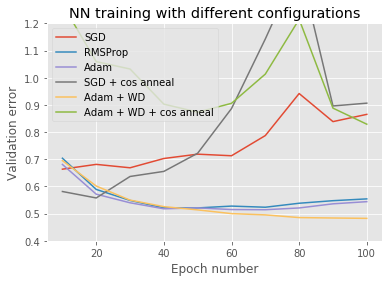

In [30]:
fig, axs = plt.subplots(1,1, figsize=(6, 4))

for idx, each in enumerate(top_res):
    stats, stat_test, keys, run_time, _, _, _, _, _ = each
    error_valid = stats[:,keys['acc(valid)']][-1]
    error_train = stats[:,keys['acc(train)']][-1]
    print("Data for", top_res_str[idx])
    print("Training time=", each[3])
    print("Train accuracy=", error_train)
    print("Valid accuracy=", error_valid)
    print("Test accuracy=", stat_test["acctest"])
    
    axs.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys["error(valid)"]], label=str(top_res_str[idx]))
    axs.legend(loc=0)
    axs.set_xlabel('Epoch number')
    axs.set_ylabel('Validation error')
    axs.set_ylim((0.4, 1.2))
    axs.set_title('NN training with different configurations')
                        
    plt.savefig("conclusion.pdf")